# Demo No. 12 - Light curve fitting.

This demo will guide you through a process of inferring parameters of the eclipsing binary from the shape of the light curve. We will start again by importing the necessary modules and setting our logging settings:

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib notebook
import os
import astropy.units as u

from elisa import settings
from elisa.analytics import LCData, LCBinaryAnalyticsTask


# setting up a custom logging config to prevent unreasonably long log messages during fit
settings.configure(LOG_CONFIG='fit')

In this particular case of KIC 4851217, we will help ourselves by using the previous results obtained from radial velocity fit. Therefore, we will use the results of the previous demo as a piece of prior knowledge for the light curve fitting procedure.

The procedure itself is very similar to the one mentioned in the previous demo 11. Initially, we will define the dataset with our Kepler phase curve:

In [5]:
kepler_data = LCData.load_from_file(filename='demo_data/lc_data/KIC04851217.lc.pulse_removed.dat', 
                                    x_unit=None, 
                                    y_unit=None
                                   )
# phasing the observations
period = 2.47028  # d
t0 = 54953.900507000006  # d

kepler_data.convert_to_phases(period, t0, centre=0.0)

Let's finally define our starting parameters. Starting parameters are divided into `system`, `primary`, `secondary` and `nuisance` (only for MCMC) categories. Model parameters are supplied in the form of dictionaries that contain the name of the variable as a key. Its corresponding value contains a dictionary characterizing starting value of the parameter, status of the parameter (fixed: True/False), the boundaries of the fitted parameter defined by `min`, `max` (, `sigma` for normal prior distribution for MCMC sampling) and finally the `unit` in astropy format. In the case of parameter `semi_major_axis`, we utilized the capability to constrain the parameter to the `system@inclination` parameter since a*sin(i) parameter has been determined during radial velocity fit:

In [6]:
lc_initial = {
    'system': {
        # setting a reasonable expected starting value and range of the parameters 
        'inclination': {  
            'value': 76.0,
            'fixed': False,
            'min': 65,
            'max': 90,
            'unit': u.deg
        },
        'eccentricity': {  
            'value': 0.02,
            'fixed': False,
            'min': 0.0,
            'max': 0.1,
        },
        # mass ratio is much more acurately determined from RV fit, therefore we will keep it fixed during initial LC fit
        'mass_ratio': {
            'value': 1.08,
            'fixed': True,
        },  
        'argument_of_periastron': {
            'value': 233,
            'fixed': False,
            'min': 0,
            'max': 360,
            'unit': u.deg
        },  
        # this parameter is constrained to orbital inclination via the `asini` derived during the RV fit
        'semi_major_axis': {
            'constraint': '11.2 / sin(radians(system@inclination))',  # IMPORTANT: only variable model parameters can be used to define a constraint
            'unit': u.solRad
        },  
        'period': {
            'value':2.47028,
            'fixed': True,
            'unit': u.d
        },
        # this parameter allows for the presence of the third light
        'additional_light': {
            'value': 0.0,
            'fixed': False,
            'min': 0.0,
            'max': 0.5,
        },
        # accounting for imprecision of the ephemeris
        'phase_shift': {
            'value': 0,
            'fixed': False,
            'min': -0.02,
            'max': 0.02,
        },
        # 'primary_minimum_time': {
        #     'value': 54953.900507000006,
        #     'fixed': True,
        #     'unit': u.d,
        # }, time of primary minimum should be supplied only in case when LCData contain light curves in BJD 
        # instad of photometric phase 
    },
    'primary': {
        # initial run will keep the primary effective temperature fixed on the value derived in the literature (Armstrong et al. 2013, MNRAS, 437, 4, 3473–3481)
        't_eff': {
            'value': 7022.0,
            'fixed': True,
            'unit': u.K
        },  # fixed to value found in literature
        'surface_potential': {
            'value': 6.1,
            'fixed': False,
            'min': 5.0,
            'max': 10.0,
        },
        # albedos and gravity darkening factors will stay fixed for the initial run
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },
        # assuming synchronized rotation at periastron
        "synchronicity": {
            "value": 1.00,
            "constraint": "(1 + system@eccentricity)**2 / (1 - system@eccentricity**2)**(3.0/2.0)",
            "unit": None
        },
        "metallicity": {
            "value": 0.0,
            "fixed": True,
            "unit": None
        }
    },
    'secondary': {
        't_eff': {
            'value': 6804,
            'fixed': False,
            'min': 3500.0,
            'max': 10000.0,
            'unit': u.K
        },
        'surface_potential': {
            'value': 6.2,
            'fixed': False,
            'min': 4.0,
            'max': 10.0,
        },
        'albedo': {
            'value': 1.0,
            'fixed': True
        },
        'gravity_darkening': {
            'value': 1.0,
            'fixed': True
        },
        "synchronicity": {
            "value": 1.00,
            "constraint": "(1 + system@eccentricity)**2 / (1 - system@eccentricity**2)**(3.0/2.0)",
            "unit": None
        },
        "metallicity": {
            "value": 0.0,
            "fixed": True,
            "unit": None
        }
    }
}

IMPORTANT: only variable model parameters (`'fixed': False`) can be used to define a constraint

Gravity darkening factors, albedos and metalicities are optional arguments, i.e. if not supplied, they will be set automatically (see demo 1) to their default values during the optimisation process.

*Important note: `LCData` used in the fitting procedure should either contain alrady phased light curves or light curves with time stamps in BJD. In case of phased `LCData` containers, set of initial parameters in `lc_initial` should not contain `primary_minimum_time` which is to be supplied only in case of light curves containing time stamps in BJD.

## Least squares method

We will start by initialising the fitting task instance, where light curves are provided in the form of a dictionary with passband names as their corresponding keys. The fitting method (`least_squares` or `mcmc`) and expected morphology need to be specified as well (`detached` or `overcontact`):

In [7]:
lst_sqr_task = LCBinaryAnalyticsTask(data={'Kepler': kepler_data}, method='least_squares', expected_morphology="detached")

Make sure that `light_curve` argument keys i.e. passband names are identical to passband names accesible for your ELISa install:

In [8]:
settings.PASSBANDS

['bolometric',
 'Generic.Bessell.U',
 'Generic.Bessell.B',
 'Generic.Bessell.V',
 'Generic.Bessell.R',
 'Generic.Bessell.I',
 'SLOAN.SDSS.u',
 'SLOAN.SDSS.g',
 'SLOAN.SDSS.r',
 'SLOAN.SDSS.i',
 'SLOAN.SDSS.z',
 'Generic.Stromgren.u',
 'Generic.Stromgren.v',
 'Generic.Stromgren.b',
 'Generic.Stromgren.y',
 'Kepler',
 'GaiaDR2',
 'TESS']

Similarly to rv_fit module, we can fit parameter combinations in `standard` and `community` approach. We can acces lists of available parameters in a similar fashion:

In [9]:
print(lst_sqr_task.FIT_PARAMS_COMBINATIONS)

{
    "standard": {
        "system": [
            "inclination",
            "eccentricity",
            "argument_of_periastron",
            "period",
            "primary_minimum_time",
            "additional_light",
            "phase_shift"
        ],
        "primary": [
            "mass",
            "t_eff",
            "surface_potential",
            "gravity_darkening",
            "albedo",
            "synchronicity",
            "metallicity",
            "spots",
            "pulsations"
        ],
        "secondary": [
            "mass",
            "t_eff",
            "surface_potential",
            "gravity_darkening",
            "albedo",
            "synchronicity",
            "metallicity",
            "spots",
            "pulsations"
        ],
        "nuisance": [
            "ln_f"
        ]
    },
    "community": {
        "system": [
            "inclination",
            "eccentricity",
            "argument_of_periastron",
            "period",


In the initial set of parameters `lc_initial`, we used the constrained parameter `semi_major_axis` with the `asini` parameter obtained during RV fit (see the previous tutorial on RV fitting). Constraint itself is provided in the form of a string. The model parameters on which constraint is dependent are provided inside the constraint expression in the format `system@parameter_name`, `primary@parameter_name` or `secondary@parameter_name`. A list of available operators and numerals that can be used to form constraint can be accessed here:

In [10]:
lst_sqr_task.CONSTRAINT_OPERATORS

['arcsin',
 'arccos',
 'arctan',
 'log',
 'sin',
 'cos',
 'tan',
 'exp',
 'degrees',
 'radians',
 '(',
 ')',
 '+',
 '-',
 '*',
 '/',
 '.',
 'e',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

The least-squares method is effective in the case where the initial parameters are in the general vicinity of the solution. Therefore, we can check the validity of the initial solution:

2022-02-02 07:50:13,349 - 14531 - binary_system.curves.c_router - INFO: one half of the curve points on the one side of the apsidal line will be interpolated


<IPython.core.display.Javascript object>


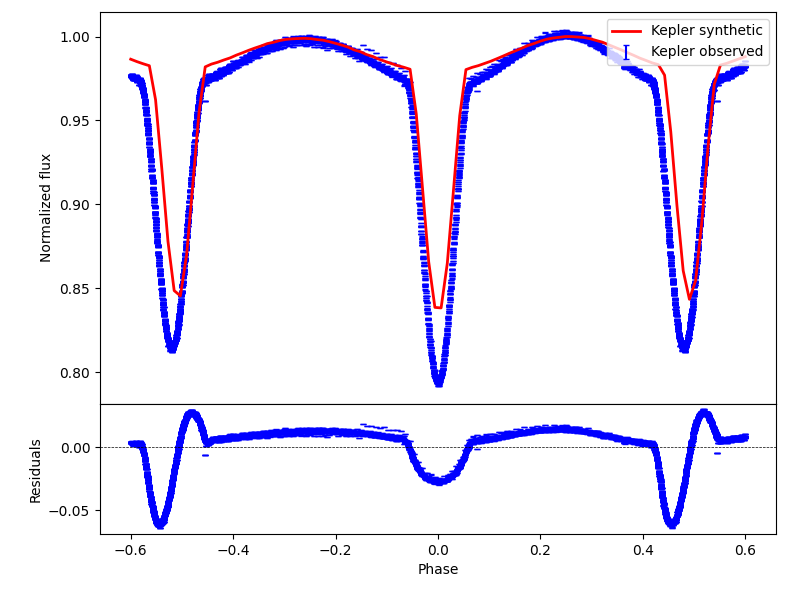

In [11]:
lst_sqr_task.set_result(lc_initial)  
# lst_sqr_task.load_result(filename)  # in case that your staring parameters are stored as a json in file 

lst_sqr_task.plot.model(discretization=10, number_of_points=100, start_phase=-0.6, stop_phase=0.6)

As we can see, the location and the relative width of the eclipses approximatelly match. Therefore, we can proceed to the fitting procedure. In cases where the initial model is too far from the solution, you can tweak the values of the `lc_initial` to obtain a better initial model.

Before the fit itself, it is recommended to make use of the multiprocessing capabilities of this package. The least-squares method is, in this instance, a serially executed method. Therefore parallelization has to be implemented during the calculation of each light curve. We can achieve this by setting configuration variable `NUMBER_OF_PROCESSES` in this script or by setting the `number_of_processes` parameter in your config file: 

In [10]:
settings.configure(NUMBER_OF_PROCESSES=os.cpu_count())  # this will make sure to utilize all available processors

We can now finally perform the fit itself. As in the previous demo, we will start with the least-squares method. Because we expect the system to be detached, we specified the `morphology` argument to be 'detached' instead of 'overcontact'. We also reduced the discretization factor of the primary component to 10 since we want to perform a quick search for the local optimum. Interpolation threshold `interp_treshold` defines a number of points in observed data sets, above which the synthetic light curve will be calculated on `interp_treshold` predefined phases and subsequently interpolated to match desired observational times. We also selected 'adaptive' instead of 'uniform' sampling of light curve points, which will generate light curve points that produce segments with equal length instead of equidistant sampling in phase. 

In [11]:
param_file = 'demo_data/assets/lc_least_squares.json'

# this part can take a while to complete in case of eccentric orbit
# lst_sqr_result = lst_sqr_task.fit(x0=lc_initial, discretization=10, interp_treshold=100, samples='adaptive')
# lst_sqr_task.save_result(param_file)

# load pre-calculated results if you don't want to wait
lst_sqr_task.load_result(param_file)
lst_sqr_result = lst_sqr_task.get_result()
lst_sqr_task.fit_summary()


BINARY SYSTEM
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                             1.08                   -                   -                None    Fixed                                             
Semi major axis (a):                               11.53                   -                   -              solRad    11.2 / sin(radians(system@inclination))           
Inclination (i):                                   76.26                   -                   -                 deg    Variable                                          
Eccentricity (e):                                   0.03                   -                   -                None    Variable                                          
Arg

The resulting model can be visualized as well:

2021-11-11 10:24:08,897 - 32142 - binary_system.curves.c_router - INFO: one half of the curve points on the one side of the apsidal line will be interpolated


<IPython.core.display.Javascript object>


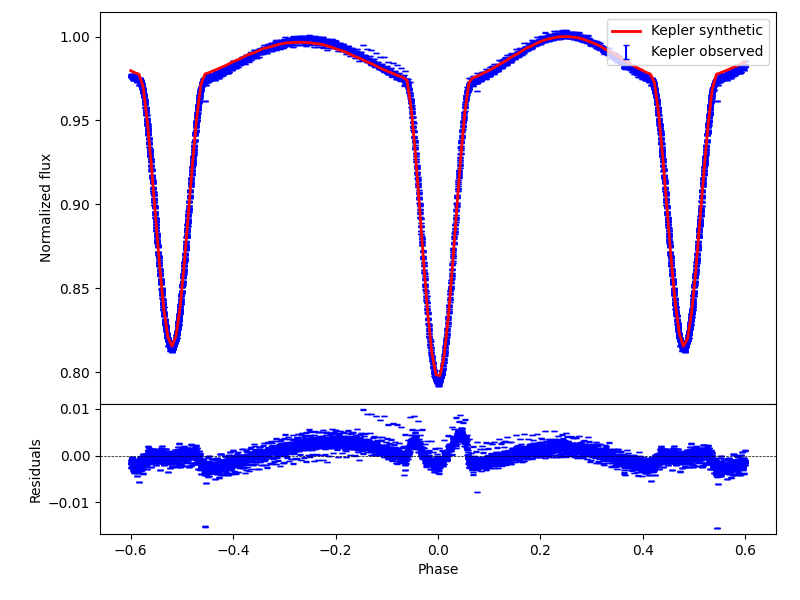

In [12]:
lst_sqr_task.plot.model(discretization=10, number_of_points=150, start_phase=-0.6, stop_phase=0.6)

This solution can be regarded as an initial solution intended as a demonstration of the fitting process. The solution can be further refined with the following steps:

- decrease the discrerization factor to 5 to reach full precision of the package,
- set additional parameters such as gravity darkening or albedo as variable to fine tune the solution, select a different limb darkening law instead of default linear law,
- use the results from previous runs of the optimizer as a basis (or directly) as a starting parameters for the next run.

The quality of the obtained solution can be always evaluated by the coefficient of the determination $R^2$:

In [13]:
lst_sqr_task.coefficient_of_determination()

2021-11-11 10:24:16,721 - 32142 - analytics.binary_fit.shared - INFO: Evaluating light curve for calculation of R^2.
2021-11-11 10:24:24,761 - 32142 - binary_system.curves.c_router - INFO: geometry of the stellar surface on one half of the apsidal line will be copied from their closest symmetrical counterparts
2021-11-11 10:24:37,832 - 32142 - analytics.binary_fit.shared - INFO: Calculation of R^2 finished.


0.9987608230244502

## Markov chain Monte Carlo (MCMC)

Markov chain Monte Carlo (MCMC) serves to produce reliable error estimates on fitted parameters of the eclipsing binary. Moreover, since this method supports a parallel approach, we can change our approach to parallelism by changing few config variables. It turns out to be much more efficient to parallelize the MCMC sampling instead of parallelizing the light curve calculation:

In [14]:
settings.configure(**{
    "NUMBER_OF_PROCESSES": 1,  # we want a single process to handle the light curve integration 
    "NUMBER_OF_MCMC_PROCESSES":os.cpu_count()  # in this case, multiple MCMC walkers will be evaluated at once, each MCMC walker will use single core to obtain the curve
})

The least-squares method had already found us an adequate solution, and the good coverage of the phase curve means that we can probably trust that solution and use it as a starting point for our MCMC sampling. Estimation of the size of the searching box for each parameter is left to the user. However, the user can assert the validity of the selected search interval by studying the traces where you should avoid any clipping of your chain distribution by the borders of the searching box if possible. With some adjustments, we will adopt results of the least square fit as our starting parameters:

In [15]:
# residual phase shift was sufficiently determined in least sqares fit, therefore it will stay fixed during mcmc sampling
lst_sqr_result['system']['phase_shift']['fixed'] = True

# lets now allow the mass ratio to be sampled from a normal distribution derived from a RV fit results
lst_sqr_result['system']['mass_ratio']= {
    'value': lst_sqr_result['system']['mass_ratio']['value'],
    'fixed': False,
    'sigma': 0.04,
    'min': 0.001, # preventing the sampler from reaching un physical regions of the parameter space
    'max': 2.0,
    'unit': None
}

# similarly, the effective temperature adopted from literature came with the error estimation
lst_sqr_result['primary']['t_eff']= {
    'value': lst_sqr_result['primary']['t_eff']['value'],
    'fixed': False,
    'sigma': 380,
    'min': 3500,  # clipping a normal distribution to (min, max) interval
    'max': 10000,
    'unit': u.K
}

# for mcmc, the nuisance parameter ln_f is used to improve the reliability of the confidence intervals
lst_sqr_result['nuisance'] = {
    'ln_f': {
        'value': -5,
        'fixed': False,
        'min': -10,
        'max': 2
    }
}

As in previous case, we need to define fitting task instance, but this time with `mcmc` in our `method` argument:

In [16]:
mcmc_task = LCBinaryAnalyticsTask(data={'Kepler': kepler_data}, method='mcmc', expected_morphology='detached')

The modified result of the least squares algorithm can now be used to perform MCMC sampling. In this case, a resulting chain will be stored on a location provided by `fit_id` argument:

In [17]:
param_file = 'demo_data/assets/lc_mcmc_params.json'
chain_file = 'demo_data/assets/lc_mcmc_chain.json'

# MCMC sampling takes a long time
# mcmc_params = mcmc_task.fit(x0=lst_sqr_result, nsteps=200, nwalkers=100, burn_in=0,
#                             discretization=10, interp_treshold=100, progress=True, fit_id=chain_file, save=True, samples='adaptive')
# mcmc_task.save_result(param_file)

# due to very time consuming nature of a MCMC sampling, we will load pre-calculated results
mcmc_task.load_result(param_file)
mcmc_task.load_chain(chain_file)
mcmc_task.fit_summary()


BINARY SYSTEM
Parameter                                          value            -1 sigma            +1 sigma                unit    status                                            
------------------------------------------------------------------------------------------------------------------------------
Mass ratio (q=M_2/M_1):                            1.077                   -                   -                None    Fixed                                             
Semi major axis (a):                              11.995                   -                   -              solRad    11.86 / sin(radians(system@inclination))          
Inclination (i):                                    81.4                 0.6                 0.2                 deg    Variable                                          
Eccentricity (e):                                 0.0338              0.0025              0.0008                None    Variable                                          
Arg

We can use function `fit summary` with argument `propagate_errors=True` to produce a detailed fit summary along with error propagation for each binary parameter. However, this procedure takes a while since every item in the chain needs to be re-evaluated as a BinarySystem to extract all parameters. With the `burn_in` parameter set only to 10 we have to inspect traces not only for any sign of clipping but also have to determine how significant a portion of the chain belongs to the thermalization stage and has to be discarded:

<IPython.core.display.Javascript object>


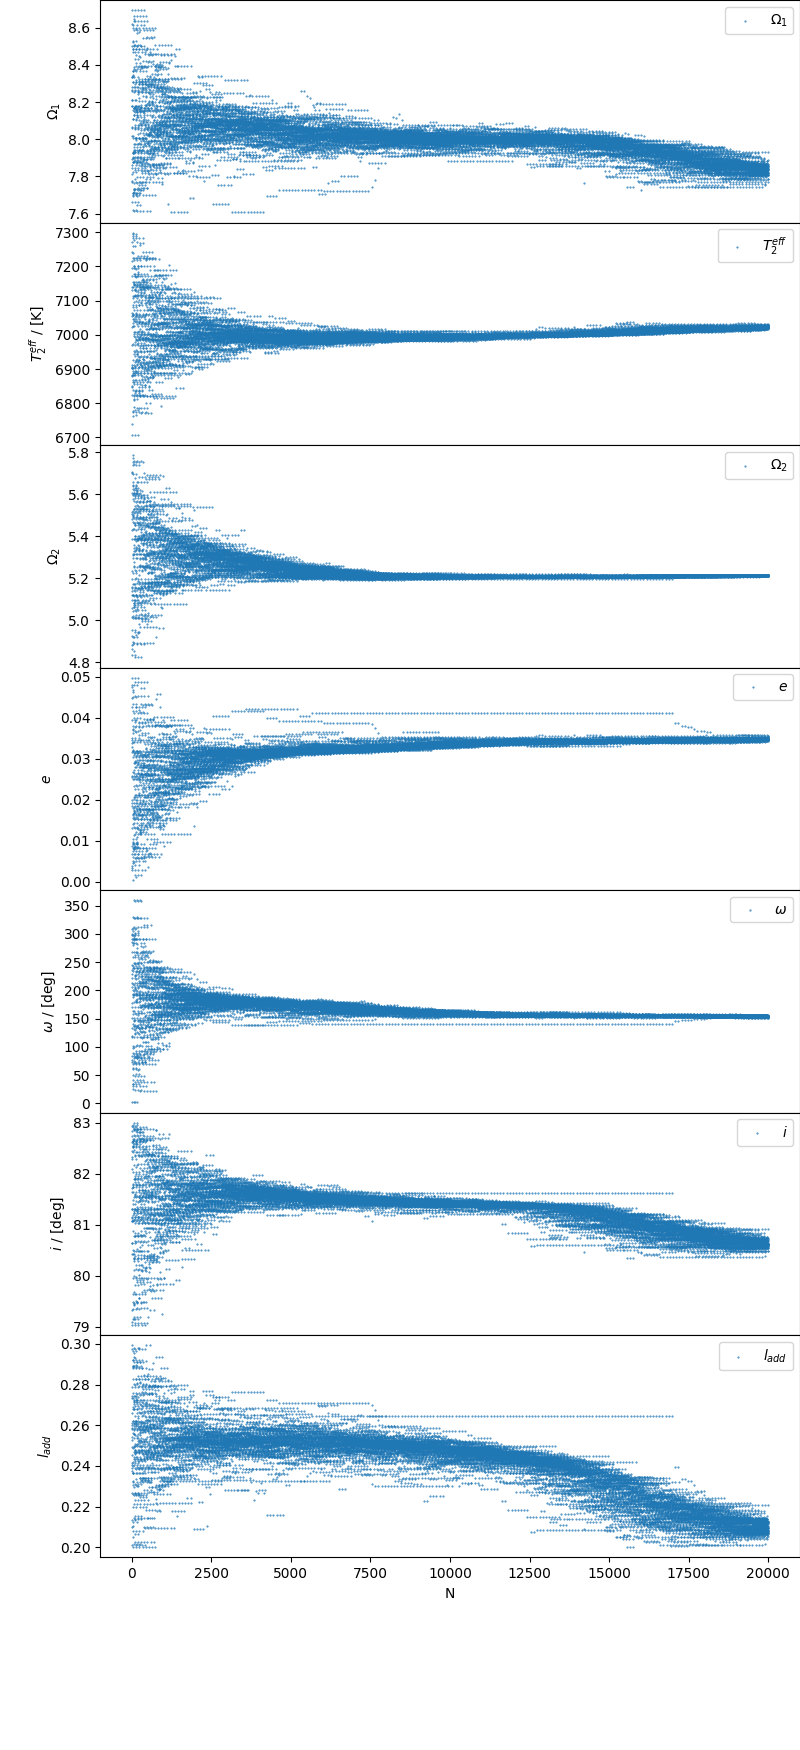

In [18]:
mcmc_task.plot.traces()

We can conclude from the figure that the chain was not able to reach sampling phase after roughly 10000 steps, therefore longer chain is needed to produce desired results. Suppose however, that the equilibrium was reached after 10000 steps and we have to discard the first 10000 steps by using `discard` argument:

In [19]:
mcmc_task.load_chain(chain_file, discard=10000)

And plot the corner plot:

<IPython.core.display.Javascript object>


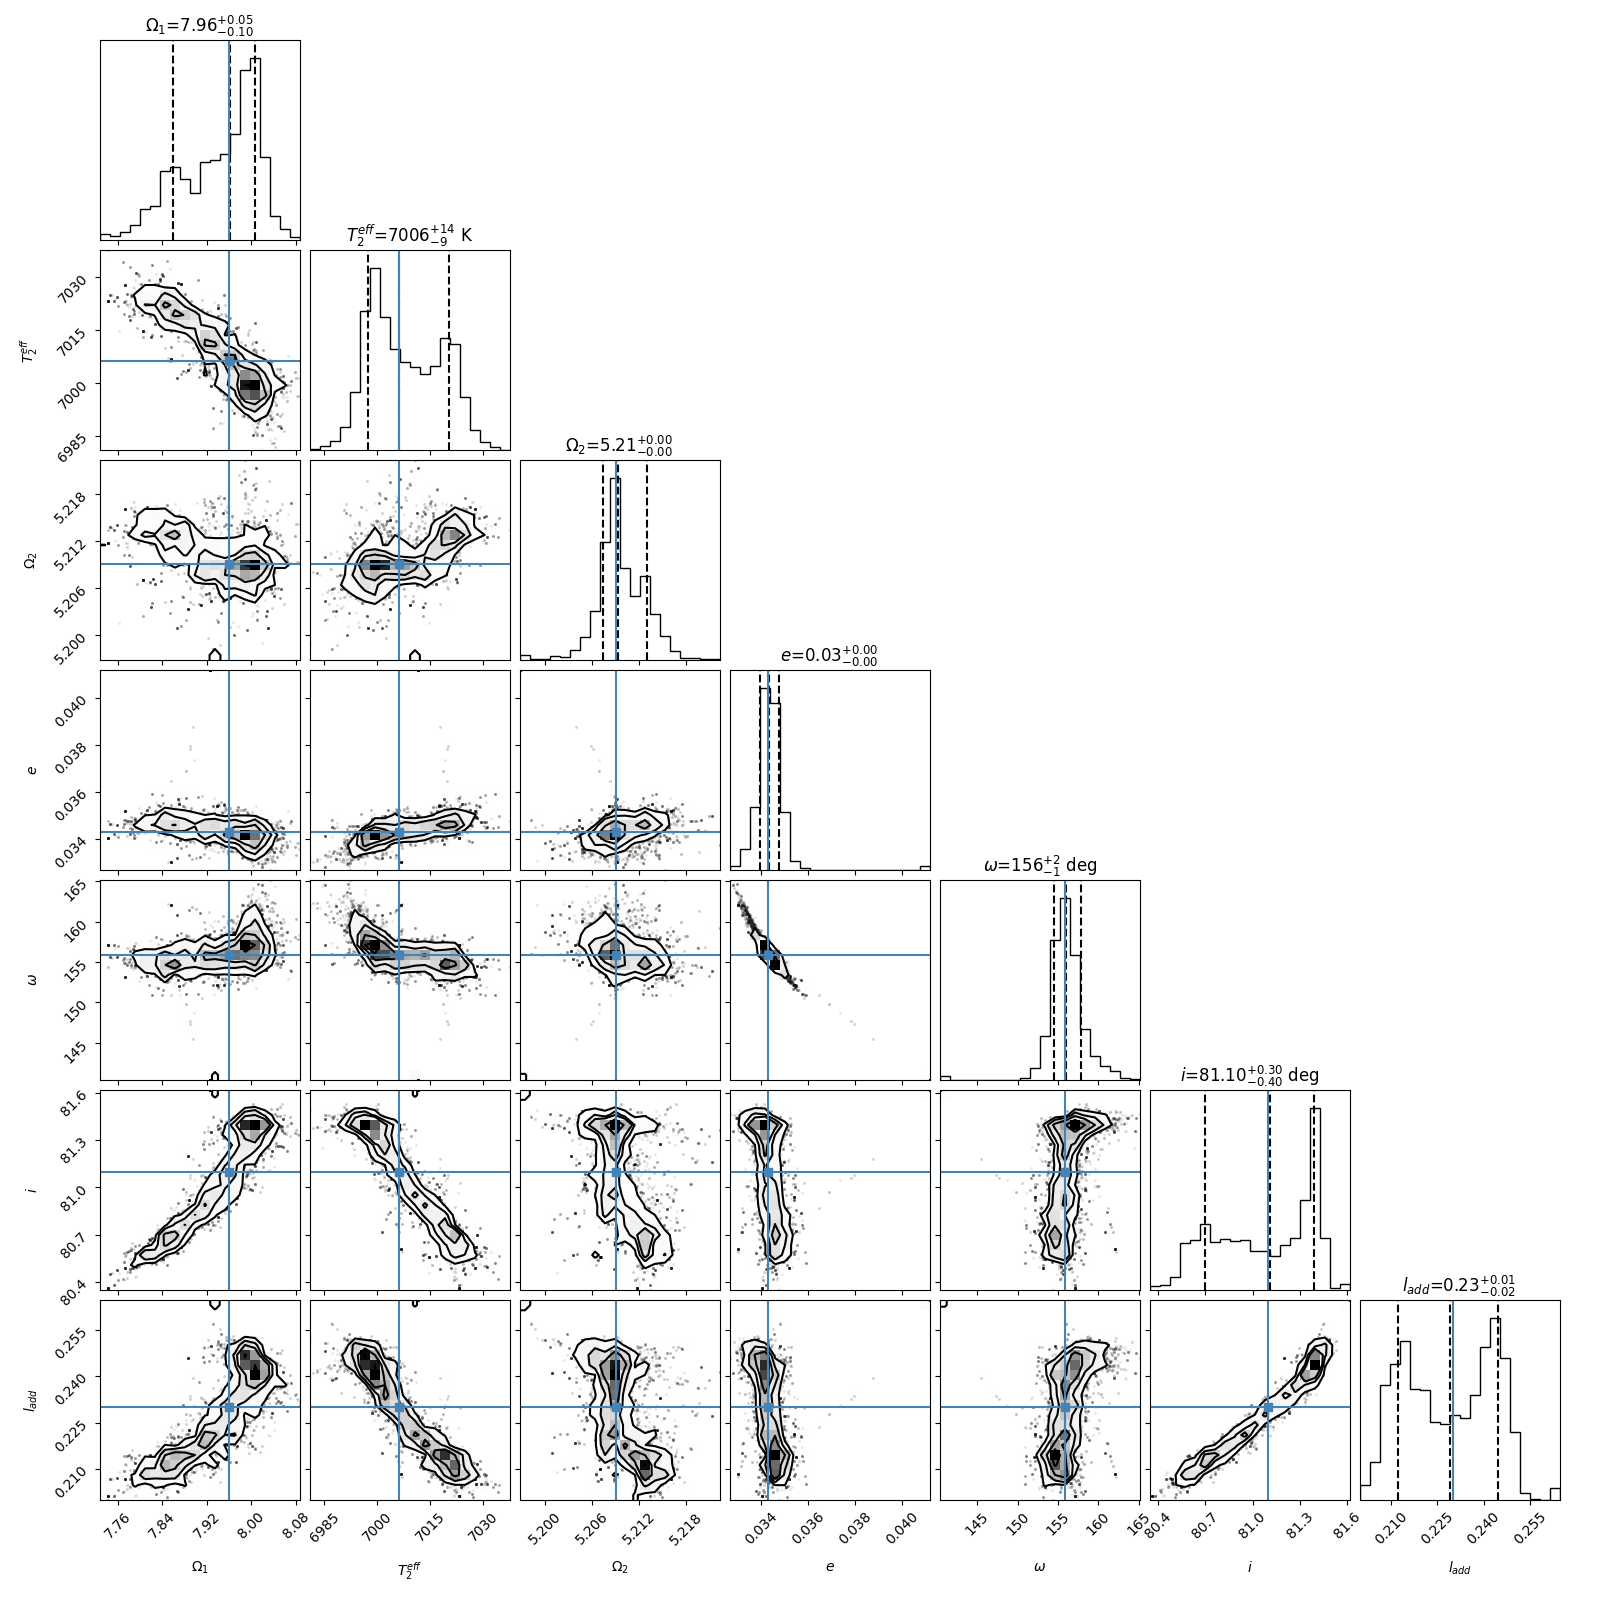

In [20]:
mcmc_task.plot.corner(truths=True)

As it is obvious from the corner plot, these results suffer from severe correlation and the longer chain is necessary to reach the sampling phase.